# Human mobility

This notebook studies the travel history data from the study cases from Magude and Matutuine districts.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from genomic_tools.pairwise import travel_map
from genomic_tools.plotting import make_pie, make_hist
from matplotlib import cm
from genomic_tools.stats import count_cases
import geopandas
from stat_tools import tables

## Importing data

We load the data to be used: 

In [2]:
#Metadata
pipeline_results_path  = "/home/apujol/isglobal/manuscripts/importation_relatedness/data/"
all_data_div_covered_samples = pd.read_csv(pipeline_results_path + 'data_filtered_for_study.csv')
#Select relevant variables
metadata = all_data_div_covered_samples[['sampleID', 'nida', 'study', 'run_id_resmark', 'year', \
                                         'region', 'province', 'district', \
                                         'us', 'age', 'sex', 'parasitemia', \
                                         '1.2 Selecione o distrito do estudo.',
                                         'date', '3.2 Data da Notificação.', \
                                         'occupation', \
                                         'travel', 'travel_prov', 'travel_dist', \
                                         'Data de Ida.', 'Data de regresso', \
                                         'latitude', 'longitude', 'travel_days', \
                                         'travel_days_728', 'source']].drop_duplicates()

#Make data a temporal variable
metadata['date'] = pd.to_datetime(metadata['date'])
#Fix inconsistent values from some variables 
metadata.loc[metadata['district'].isnull(), 'district'] = metadata.loc[metadata['district'].isnull(), '1.2 Selecione o distrito do estudo.']
metadata.loc[metadata['province'] == 'Maputo Provincia', 'province'] = 'Maputo'
metadata.loc[metadata['province'] == 'Maputo Cidade', 'province'] = 'Maputo City'
metadata.loc[metadata['travel_prov'] == 'ZAMBEZIA', 'travel_prov'] = 'Zambezia'
metadata.loc[metadata['travel_prov'] == 'ZAMBEZIA (QUELIMANE)', 'travel_prov'] = 'Zambezia'
metadata.loc[metadata['travel_prov'] == 'INHAMBANE', 'travel_prov'] = 'Inhambane'
metadata.loc[metadata['travel_prov'] == 'GAZA', 'travel_prov'] = 'Gaza'
metadata.loc[metadata['travel_prov'] == 'MASSINGA', 'travel_prov'] = 'Inhambane'
metadata.loc[metadata['travel_prov'] == 'QUELIMANE', 'travel_prov'] = 'Zambezia'
metadata.loc[metadata['travel_prov'] == 'SOFALA', 'travel_prov'] = 'Sofala'
metadata.loc[metadata['travel_prov'] == 'CHIBUTO', 'travel_prov'] = 'Gaza'
metadata.loc[metadata['travel_prov'] == 'BEIRA', 'travel_prov'] = 'Sofala'
metadata.loc[metadata['travel_prov'] == 'NAMPULA', 'travel_prov'] = 'Nampula'
metadata.loc[metadata['travel_prov'] == 'MANICA', 'travel_prov'] = 'Manica'
metadata.loc[metadata['travel_prov'] == 'NIASSA', 'travel_prov'] = 'Niassa'
metadata.loc[metadata['travel_prov'] == 'MAPUTO', 'travel_prov'] = 'Maputo'
metadata.loc[metadata['travel_prov'] == 'Maputo Provincia', 'travel_prov'] = 'Maputo'
metadata.loc[metadata['travel_prov'] == 'Maputo Province', 'travel_prov'] = 'Maputo'
metadata.loc[metadata['travel_prov'] == 'Maputo Cidade', 'travel_prov'] = 'Maputo City'
metadata.loc[metadata['district'] == 'Matutine', 'district'] = 'Matutuine'

/tmp/ipykernel_125645/4291547709.py:3: DtypeWarning: Columns (12,13,15,18,19,22,24,25,28,29,30,31,32,33,34,35,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data_div_covered_samples = pd.read_csv(pipeline_results_path + 'data_filtered_for_study.csv')


## Loading IBD results

We load the IBD results obtained from Dcifer:

In [3]:
#Path where the results are stored
ibd_data_path = pipeline_results_path
#Load results
ibd_res_filename = ibd_data_path + "ibd_results.csv"
ibd_res = pd.read_csv(ibd_res_filename)
ibd_pval_filename = ibd_data_path + "ibd_results_p_value.csv"
ibd_pval = pd.read_csv(ibd_pval_filename)
ibd_res.index = ibd_res.columns
ibd_pval.index = ibd_pval.columns

#We merge the IBD results with metadata
ibd_res_meta = pd.merge(ibd_res, metadata, left_index = True, right_on = 'sampleID', how = 'left')
ibd_pval_meta = pd.merge(ibd_pval, metadata, left_index = True, right_on = 'sampleID', how = 'left')

## Analysis

This is the total number of travels reported in Magude and Matutuine districts. Notice that some cases will be excluded from the analysis for not residing in the area. 

In [4]:
#Counting sample sizes
react_mask = (metadata['source'] == 'REACT2')&(metadata['province'] == 'Maputo')
print("Number of REACT samples with sequenced data:", np.sum(react_mask))
ds_with_meta = (react_mask)&metadata['travel'].notnull()&((metadata['district'] == 'Matutuine') | (metadata['district'] == 'Magude'))
print("Dense sampling participants with data:", np.sum(ds_with_meta))
travelled_ds = (ds_with_meta)&metadata['travel_prov'].notnull()
print("Total number of Dense sampling participants:", np.sum(travelled_ds))

Number of REACT samples with sequenced data: 534
Dense sampling participants with data: 207
Total number of Dense sampling participants: 107


Here we show their travel destinations: 

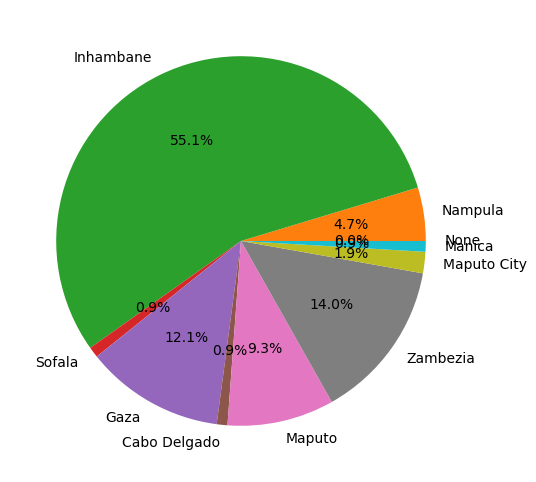

Number and fraction of cases:
None:         0	0.0%
Nampula:      5	4.7%
Inhambane:    59	55.1%
Sofala:       1	0.9%
Gaza:         13	12.1%
Cabo Delgado: 1	0.9%
Maputo:       10	9.3%
Zambezia:     15	14.0%
Maputo City:  2	1.9%
Manica:       1	0.9%


In [5]:
make_pie(metadata[travelled_ds]['travel_prov'], verbose = True, ignore_null= False)

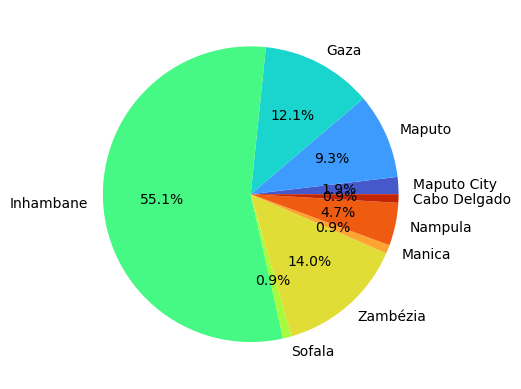

In [6]:
labels = ['Maputo City', 'Maputo', 'Gaza', 'Inhambane', \
          'Sofala', 'Zambézia', 'Manica', \
          'Nampula', 'Cabo Delgado']
counts = [2, 10, 13, 59, 1, 15, 1, 5, 1]
colors = [cm.turbo((i+1)/(len(labels)+1)) for i in range(len(labels))]
plt.pie(counts, labels = labels, colors = colors, autopct='%1.1f%%')
plt.savefig("/home/apujol/isglobal/manuscripts/importation_relatedness/figs/pie_travels.png")
plt.savefig("/home/apujol/isglobal/manuscripts/importation_relatedness/figs/pie_travels.pdf")
plt.show()

### Travel analysis for Dense samples

Here we show the statistics of travels and travel destinations:

In [7]:
traveled_samples = list(ibd_res_meta[travelled_ds]['sampleID'])
destiny_samples = list(ibd_res_meta[travelled_ds]['travel_prov'])
province_samples = list(ibd_res_meta[travelled_ds]['province'])
orig_dest_travels = [str(province_samples[i]) + '->' + str(destiny_samples[i]) \
                     for i in range(len(destiny_samples))]

/tmp/ipykernel_125645/501675.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  traveled_samples = list(ibd_res_meta[travelled_ds]['sampleID'])
/tmp/ipykernel_125645/501675.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  destiny_samples = list(ibd_res_meta[travelled_ds]['travel_prov'])
/tmp/ipykernel_125645/501675.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  province_samples = list(ibd_res_meta[travelled_ds]['province'])


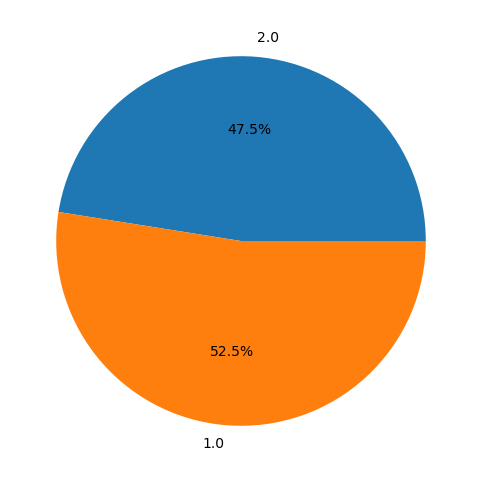

Number and fraction of cases:
2.0: 104	47.5%
1.0: 115	52.5%
Number of participants from dense sampling who travelled (1) or not (2) from the different districts:


,2.0,1.0
Magude,25.0,3.0
Matutuine,75.0,104.0
Katembe,1.0,1.0
Cidade de Maxixe,0.0,1.0
KaMaxakeni,0.0,1.0
Boane,3.0,2.0
Gondola,0.0,1.0
Namacurra,0.0,1.0
Cidade da Matola,0.0,1.0


In [62]:
make_pie(metadata[metadata['source'] == 'REACT2']['travel'], verbose = True)
print("Number of participants from dense sampling who travelled (1) or not (2) from the different districts:")
tables.labels_2d(metadata[metadata['source'] == 'REACT2'], 'district', 'travel')

### Showing tables and maps of travels

In [8]:
table_orig_dest = tables.labels_2d(ibd_res_meta[travelled_ds], 'province', 'travel_prov')

/tmp/ipykernel_125645/3054397724.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  table_orig_dest = tables.labels_2d(ibd_res_meta[travelled_ds], 'province', 'travel_prov')


In [9]:
table_orig_dest

,Cabo Delgado,Gaza,Inhambane,Manica,Maputo,Maputo City,Nampula,Sofala,Zambezia
Maputo,1,13,59,1,10,2,5,1,15


In [10]:
#We define the GPS location of the provinces
list_locs = {
    'Maputo' : [32.888582, -26.843370], #Punta do Ouro
    'Maputo City' : [32.576388888888889, -25.915277666666],
    'Magude' : [32.64216410, -25.02049992], 
    'Massinga' : [35.37405260,-23.32666250], 
    'Gaza' : [34.19153, -24.9206],#Chidenguele HF
    'Inhambane' : [35.38, -23.33456],#Massinga
    'Zambézia' : [35.71279, -17.97899],#Mopeia
    'Cabo Delgado' : [38.99972150, -13.12555980],#Montepuez
    'Tete' : [33.618156, -16.138187],#Tete
    'Sofala' : [34.846280, -19.833158],#Beira
    'Niassa' : [36.36631, -14.9154], #Cuamba Titimane
    'Manica' : [33.34914, -17.41963], #Guro sede
    'Nampula' : [39.26173, -15.123], #Hospital Geral de Nampula distrito
    }
locations = pd.DataFrame({'location' : [i for i in list_locs], 'longitude': [list_locs[i][0] for i in list_locs], 'latitude': [list_locs[i][1] for i in list_locs]})
locations = geopandas.GeoDataFrame(locations, geometry = geopandas.points_from_xy(locations['longitude'], locations['latitude']))
locations = locations.set_crs(epsg=4326)

list_provs = {}
for prov in ['Maputo City', 'Maputo', 'Gaza', 'Inhambane', \
              'Manica', 'Sofala', 'Tete', 'Zambézia', \
               'Niassa', 'Nampula', 'Cabo Delgado']:
    list_provs[prov] = list_locs[prov]

provinces = pd.DataFrame({'location' : [i for i in list_provs], 'longitude': [list_provs[i][0] for i in list_provs], 'latitude': [list_provs[i][1] for i in list_provs]})
provinces = geopandas.GeoDataFrame(provinces, geometry = geopandas.points_from_xy(provinces['longitude'], provinces['latitude']))
provinces = provinces.set_crs(epsg=4326)

In [11]:
table_orig_dest.columns = ['Cabo Delgado', 'Gaza', 'Inhambane', 'Manica', 'Maputo', 'Maputo City',
       'Nampula', 'Sofala', 'Zambézia']

Here we map these travel destinations, with the width and colour of the lines proportional to the number of travels reported: 

Maputo Cabo Delgado
Maputo Gaza
Maputo Inhambane
Maputo Manica
Maputo Maputo
Maputo Maputo City
Maputo Nampula
Maputo Sofala
Maputo Zambézia
Maputo Maputo


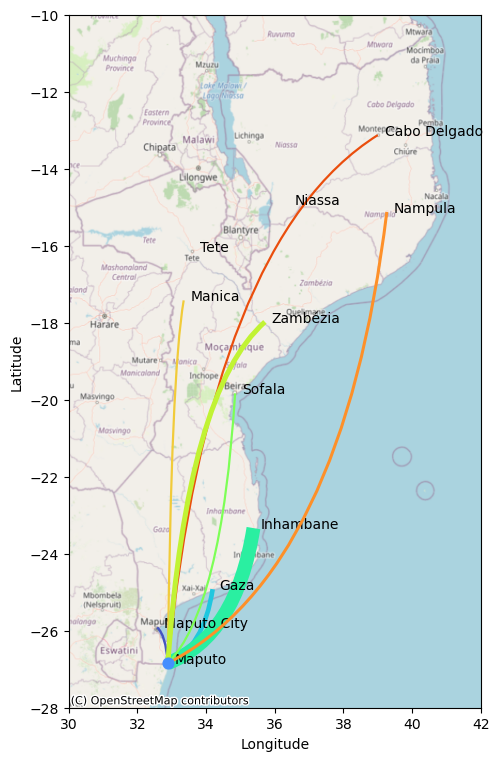

In [14]:
positions = [8,2,3,6,1,0,7,4,5, 1]
col_list = [cm.turbo((positions[i]+1)/(len(positions)+1)) for i in range(len(positions))]
travel_map(table_orig_dest+10, list(table_orig_dest.index), \
           list(table_orig_dest.columns), provinces, color = 'list', \
           linewidth='prop', alpha = 1, print_locations=True, color_list = col_list)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("/home/apujol/isglobal/manuscripts/importation_relatedness/figs/travel_map_locs_new_colors.png")
plt.savefig("/home/apujol/isglobal/manuscripts/importation_relatedness/figs/travel_map_locs_new_colors.pdf")

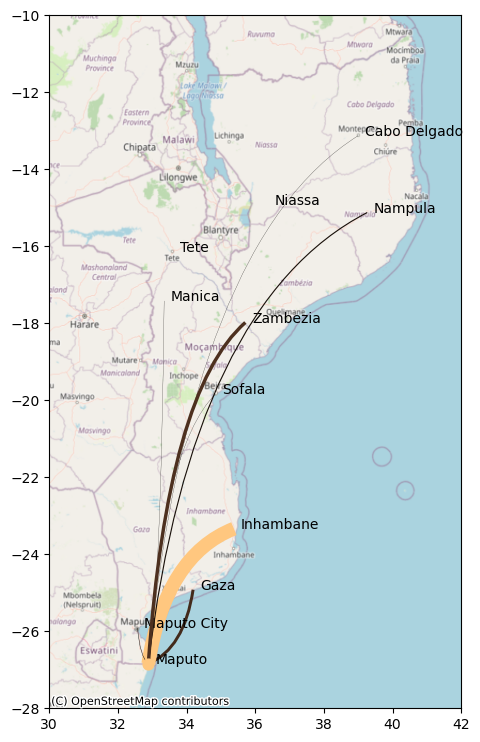

In [16]:
travel_map(table_orig_dest, list(table_orig_dest.index), \
           list(table_orig_dest.columns), provinces, color = 'auto', \
           linewidth='prop', alpha = 1, print_locations=True)
#plt.savefig("/home/apujol/isglobal/manuscripts/importation_relatedness/figs/travel_map_locs.png")
#plt.savefig("/home/apujol/isglobal/manuscripts/importation_relatedness/figs/travel_map_locs.pdf")